# Uncertainty Quantification based on Gaussian Reconstructions

The Gaussian reconstructions have 2.5 times the added noise to the k-space before reconstruction with vSHARP.

In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Paths
VSHARP_R1_ROOT = Path(f"/scratch/hb-pca-rad/projects/03/SOMETHING")
VSHARP_R3_ROOT = Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x")
VSHARP_R6_ROOT = Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x")

# All patient IDs
PAT_IDS            = ['0003_ANON5046358']

# Parameters 
DECIMALS           = 4 # number of decimals to round to

## Only load all the reconstructions, then we process them after loading

In [4]:
def norm_rescale01(recon: np.ndarray) -> np.ndarray:
    """
    Normalize and rescale the reconstructions to [0, 1].
    
    Args:
        recon (np.ndarray): 3D NumPy array with shape (slices, rows, cols).
    
    Returns:
        np.ndarray: Normalized and rescaled 3D NumPy array.
    """
    assert isinstance(recon, np.ndarray), "recon must be a NumPy array."

    # Add a small epsilon to avoid division by zero.
    return (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)


def load_reconstructions_pat(pat_root: Path, norm=False, debug=False) -> np.ndarray:
    """
    Load and optionally normalize reconstructions from .h5 files in the given directory.
    
    Args:
        pat_root (Path): Path to the directory containing .h5 files.
        norm (bool): Whether to normalize the reconstructions.
        debug (bool): Whether to print debug information.
    
    Returns:
        np.ndarray: 4D NumPy array with shape (num_files, slices, rows, cols).
    """
    h5_files = list(pat_root.glob('*.h5'))
    if debug:
        print(f"Found {len(h5_files)} .h5 files\n")

    recons = []
    for idx, h5_file in enumerate(h5_files):
        if debug:
            print(f'\nProcessing: {h5_file.name}, with gaussian_id: {str(h5_file.stem).split("_")[-1]} ({idx+1}/{len(h5_files)})')
        with h5py.File(h5_file, 'r') as f:
            recon = f['reconstruction'][()]
            if norm:
                recon = norm_rescale01(recon)
            if debug:
                print(f"Shape: {recon.shape}, Max: {recon.max():.7f}, Min: {recon.min():.7f}, Mean: {recon.mean():.7f}, Std: {recon.std():.7f}")
            recons.append(recon)
    
    recons_4d = np.stack(recons)
    if debug:
        print(f"Shape of recons_4d: {recons_4d.shape}")
    return recons_4d 




###### Main ########
# Load reconstructions for all patients in pat_ids_r6
recons_r3 = [load_reconstructions_pat(VSHARP_R3_ROOT / pat_id, norm=True, debug=True) for pat_id in PAT_IDS]
recons_r6 = [load_reconstructions_pat(VSHARP_R6_ROOT / pat_id, norm=True, debug=True) for pat_id in PAT_IDS]

Found 13 .h5 files


Processing: meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2_gaus7.h5, with gaussian_id: gaus7 (1/13)
Shape: (30, 768, 651), Max: 0.9999904, Min: 0.0000000, Mean: 0.0648217, Std: 0.0658112

Processing: meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2_gaus9.h5, with gaussian_id: gaus9 (2/13)
Shape: (30, 768, 651), Max: 0.9999903, Min: 0.0000000, Mean: 0.0664172, Std: 0.0666018

Processing: meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2_gaus12.h5, with gaussian_id: gaus12 (3/13)
Shape: (30, 768, 651), Max: 0.9999903, Min: 0.0000000, Mean: 0.0663849, Std: 0.0666695

Processing: meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2_gaus3.h5, with gaussian_id: gaus3 (4/13)
Shape: (30, 768, 651), Max: 0.9999902, Min: 0.0000000, Mean: 0.0664952, Std: 0.0666810

Processing: meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2_gaus6.h5, with gaussian_id: gaus6 (5/13)
Shape: (30, 768, 651), Max: 0.9999903, Min: 0.0000000, Mean: 0.0656061, Std: 0.0658500

Processing: meas_

# Actual Uncertainty Quantification with STD and visualization

We also apply a percentile tresholding to view uncertain parts. I dont know if 95% makes sense, but we go with it for now.

Shape of uncertainty map: (30, 768, 651)
Min max of the uncertainty map (rounded): 0.0003000000142492354 - 0.021199999377131462
Rounding uncertainty map to 4 decimals


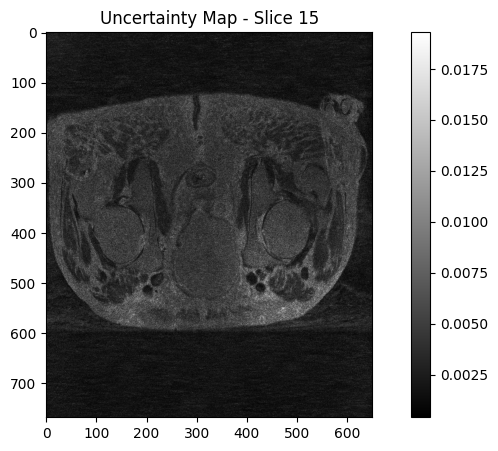

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map.nii.gz
Applying percentile threshold: 99%
Threshold value: 0.00908801332116127
Rounding uncertainty map to 4 decimals


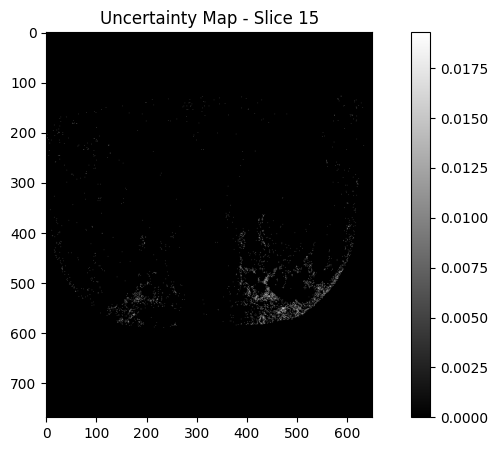

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map_th99.nii.gz
Applying percentile threshold: 95%
Threshold value: 0.007006470579653978
Rounding uncertainty map to 4 decimals


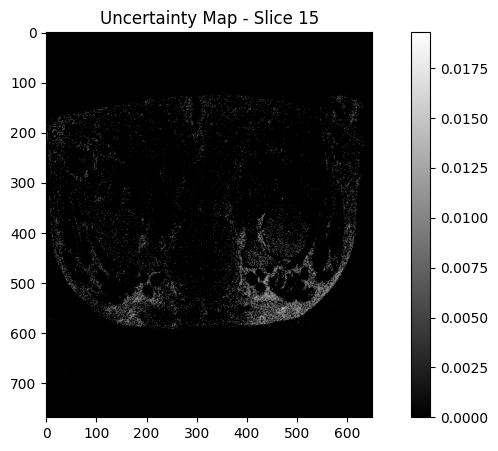

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map_th95.nii.gz


In [5]:
def calculate_uncertainty_map(reconstructions: np.ndarray, debug=False) -> np.ndarray:
    """
    Calculate the uncertainty map by computing the standard deviation across reconstructions.
    
    Args:
        reconstructions (np.ndarray): 4D NumPy array with shape (num_reconstructions, slices, rows, cols).
    
    Returns:
        np.ndarray: 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
    """
    assert isinstance(reconstructions, np.ndarray), "reconstructions must be a NumPy array."
    assert reconstructions.ndim == 4, f"Expected 4D array, got {reconstructions.ndim}D array."
    
    uq_map = reconstructions.std(axis=0)
    if debug: 
        print(f"Shape of uncertainty map: {uq_map.shape}")
        print(f"Min max of the uncertainty map (rounded): {np.round(uq_map.min(), 4)} - {np.round(uq_map.max(), 4)}")
    return uq_map


def visualize_uncertainty_map(uq_map: np.ndarray, slice_idx: int = 0, save_path: Path = None, do_round = False, decimals = 3):
    """
    Visualize the uncertainty map and optionally save it as a NIfTI file.
    
    Args:
        uq_map (np.ndarray): 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
        slice_idx (int): Index of the slice to visualize.
        save_path (Path): Path to save the uncertainty map as a NIfTI file. If None, the map is not saved.
    """
    assert isinstance(uq_map, np.ndarray), "uq_map must be a NumPy array."
    assert uq_map.ndim == 3, f"Expected 3D array, got {uq_map.ndim}D array."
    assert 0 <= slice_idx < uq_map.shape[0], f"slice_idx out of range (0 to {uq_map.shape[0]-1})"
    
    # if the data is nicely between 0 and 1, we can use the 'gray' colormap and we can round 
    if do_round:
        print(f'Rounding uncertainty map to {decimals} decimals')
        uq_map = np.round(uq_map, decimals)

    # Plotting
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(uq_map[slice_idx], cmap='gray')
    plt.colorbar()
    plt.title(f'Uncertainty Map - Slice {slice_idx}')
    plt.show()
    
    # Save as NIfTI file if save_path is provided
    if save_path:
        uq_map_sitk = sitk.GetImageFromArray(uq_map)
        sitk.WriteImage(uq_map_sitk, str(save_path))
        print(f'Saved uncertainty map as {save_path}')


def apply_percentile_threshold(uq_map: np.ndarray, percentile: float = 95.0, debug=False) -> np.ndarray:
    """
    Apply a percentile threshold to the uncertainty map, keeping only the top percentile values.
    
    Args:
        uq_map (np.ndarray): 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
        percentile (float): Percentile threshold to apply. Default is 95.0.
    
    Returns:
        np.ndarray: Thresholded uncertainty map with the same shape as input.
    """
    assert isinstance(uq_map, np.ndarray), "uq_map must be a NumPy array."
    assert uq_map.ndim == 3, f"Expected 3D array, got {uq_map.ndim}D array."
    
    threshold_value = np.percentile(uq_map, percentile)
    if debug:
        print(f"Applying percentile threshold: {percentile}%")
        print(f"Threshold value: {threshold_value}")
    
    thresholded_uq_map = np.where(uq_map >= threshold_value, uq_map, 0)
    return thresholded_uq_map


###### Main ######
for idx, recons in enumerate(recons_r6):
    pat_dir = VSHARP_R6_ROOT / PAT_IDS[idx]

    uq_map = calculate_uncertainty_map(recons_r6[idx], debug = True)
    visualize_uncertainty_map(uq_map, slice_idx=15, save_path=pat_dir / 'uq_map.nii.gz', do_round=True, decimals=DECIMALS)

    threshold = 99
    uq_map_th = apply_percentile_threshold(uq_map, percentile=threshold, debug=True)
    visualize_uncertainty_map(uq_map_th, slice_idx=15, save_path=pat_dir / Path(str(f'uq_map_th{int(threshold)}.nii.gz')), do_round=True, decimals=DECIMALS)

    threshold = 95
    uq_map_th = apply_percentile_threshold(uq_map, percentile=threshold, debug=True)
    visualize_uncertainty_map(uq_map_th, slice_idx=15, save_path=pat_dir / Path(str(f'uq_map_th{int(threshold)}.nii.gz')), do_round=True, decimals=DECIMALS)
    break